<a href="https://colab.research.google.com/github/tanatiem/BADS7105-CRM-Analytics/blob/main/Homework%2008%20-%20Campaign%20Response%20Model/hw08_campaign_response_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initalization

In [2]:
!pip install lifetimes

     |████████████████████████████████| 593kB 19.6MB/s 


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [4]:
%cd "/content/drive/My Drive/BADS/7105 CRM/work/08 - Campaign Response Model"

/content/drive/My Drive/BADS/7105 CRM/work/08 - Campaign Response Model


# Load Dataset

In [5]:
df_response = pd.read_csv('Retail_Data_Response.csv')
print(df_response.shape)

df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])
print(df_transactions.shape)

(6884, 2)
(125000, 3)


In [8]:
print(f'Shape: {df_response.shape}')
print(f'Unique: {df_response.customer_id.nunique()}')
df_response.head()

Shape: (6884, 2)
Unique: 6884


,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [9]:
print(f'Shape: {df_transactions.shape}')
print(f'Unique: {df_transactions.customer_id.nunique()}')
df_transactions.head()

Shape: (125000, 3)
Unique: 6889


,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [10]:
set(df_transactions.customer_id).difference(df_response.customer_id)

{'CS7297', 'CS7413', 'CS7638', 'CS8376', 'CS8753'}

In [11]:
df_transactions['tran_amount'].describe()

count    125000.000000
mean         64.991912
std          22.860006
min          10.000000
25%          47.000000
50%          65.000000
75%          83.000000
max         105.000000
Name: tran_amount, dtype: float64

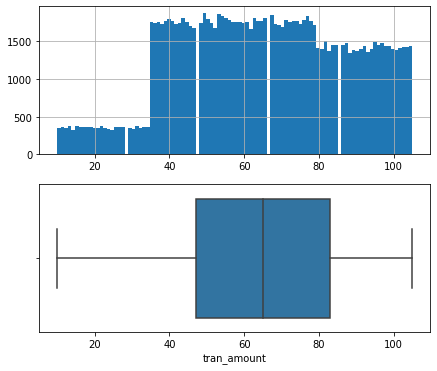

In [12]:
fig, axes = plt.subplots(2,1, figsize=(7,6))
df_transactions['tran_amount'].hist(bins=100, ax=axes[0])
sns.boxplot(data=df_transactions, x='tran_amount', ax=axes[1]);

In [13]:
df_transactions['trans_date'].min(), df_transactions['trans_date'].max()

(Timestamp('2011-05-16 00:00:00'), Timestamp('2015-03-16 00:00:00'))

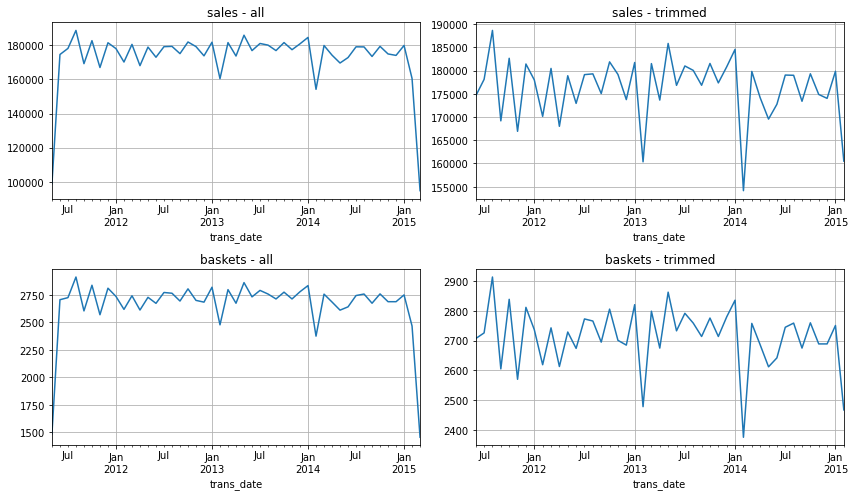

In [14]:
# df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].sum().iloc[1:-1].plot()
fig, axes = plt.subplots(2,2, figsize=(12,7), tight_layout=True)
axes = axes.ravel()

df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].sum().plot(title='sales - all', ax=axes[0])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].sum().iloc[1:-1].plot(title='sales - trimmed', ax=axes[1])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].size().plot(title='baskets - all', ax=axes[2])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].size().iloc[1:-1].plot(title='baskets - trimmed', ax=axes[3])
for ax in axes:
    ax.grid(True)

plt.show()

# Data Prep

In [15]:
random_state = 18
campaign_date = dt.datetime(2015,3,17)

df_transactions['age'] = (campaign_date - df_transactions['trans_date']).dt.days
df_transactions['weekend'] = df_transactions['trans_date'].dt.weekday.isin([5,6])

basket_cuts = [0,35,80,float('inf')]
df_transactions['basket_size'] = pd.cut(df_transactions['tran_amount'], basket_cuts, right=False, labels=['S','M','L'])

df_transactions = df_transactions.sort_values(['customer_id','trans_date'])
df_transactions.head()

,customer_id,trans_date,tran_amount,age,weekend,basket_size
77247,CS1112,2011-06-15,56,1371,False,M
89149,CS1112,2011-08-19,96,1306,False,L
68206,CS1112,2011-10-02,60,1262,True,M
36486,CS1112,2012-04-08,56,1073,True,M
93074,CS1112,2012-06-24,52,996,True,M


## Feature Engineering

In [16]:
print(df_transactions['trans_date'].max())
last_date = dt.datetime(2015,3,16)
print(f" 3 months: {last_date - dt.datetime(2014,12,16)}")
print(f" 6 months: {last_date - dt.datetime(2014,9,16)}")
print(f"12 months: {last_date - dt.datetime(2014,3,16)}")
print(f"18 months: {last_date - dt.datetime(2013,9,16)}")
print(f"24 months: {last_date - dt.datetime(2013,3,16)}")

2015-03-16 00:00:00
 3 months: 90 days, 0:00:00
 6 months: 181 days, 0:00:00
12 months: 365 days, 0:00:00
18 months: 546 days, 0:00:00
24 months: 730 days, 0:00:00


In [17]:
df = df_transactions.groupby('customer_id').agg(
        recency=('age', min),                       
        frequency=('customer_id', len),                  
        monetary=('tran_amount', sum), 
        tenure=('age', max),
        length_of_stay=('age', lambda x: x.max() - x.min()),
     )
# basket size stats
basket_size_df = df_transactions.groupby(['customer_id','basket_size'])['tran_amount'].agg(['size','sum']).unstack()
basket_size_df.columns = ['visit_basket_s','visit_basket_m','visit_basket_l','spend_basket_s','spend_basket_m','spend_basket_l']
df = df.join(basket_size_df)

df = df.join(df_transactions.groupby('customer_id').agg(
    ticket_size=('tran_amount','mean'),
    std_ticket_size=('tran_amount','std'),
    med_ticket_size=('tran_amount','median'),
    mad_ticket_size=('tran_amount','mad')
))

event_df = df_transactions.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
event_df['num_repeat_sameday'] = event_df['num_trans'] - 1
event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days

df = df.join(event_df.groupby('customer_id').agg(avg_duration=('duration','mean'),std_duration=('duration','std'),
                                                # med_duration=('duration','median'), mad_duration=('duration','mad'),
                                                num_repeat_periods=('trans_date', lambda x: x.count() - 1),
                                                num_repeat_sameday=('num_repeat_sameday','sum')))

# df['recency_score'] = (df['recency'] - df['avg_duration'])/df['std_duration']
df['recency_score'] = np.log(df['recency'] / df['avg_duration'])


# df = df.join(df_transactions.loc[df_transactions['trans_date'] > '2014-12-16'].groupby('customer_id')['tran_amount'].agg(monetary_3m='sum',frequency_3m='size'))
# df['ticket_size_3m'] = df['monetary_3m'] / df['frequency_3m']
# df['monthly_spend_3m'] = df['monetary_3m'] / 3
# df['monthly_visit_3m'] = df['frequency_3m'] / 3

df = df.join(df_transactions.loc[df_transactions['trans_date'] > '2014-09-16'].groupby('customer_id')['tran_amount'].agg(monetary_6m='sum',frequency_6m='size'))
df['ticket_size_6m'] = df['monetary_6m'] / df['frequency_6m']
df['monthly_spend_6m'] = df['monetary_6m'] / 6
df['monthly_visit_6m'] = df['frequency_6m'] / 6

df = df.join(df_transactions.loc[df_transactions['trans_date'] > '2014-03-16'].groupby('customer_id')['tran_amount'].agg(monetary_12m='sum',frequency_12m='size'))
df['ticket_size_12m'] = df['monetary_12m'] / df['frequency_12m']
df['monthly_spend_12m'] = df['monetary_12m'] / 12
df['monthly_visit_12m'] = df['frequency_12m'] / 12

df = df.join(df_transactions.loc[df_transactions['trans_date'] > '2013-09-16'].groupby('customer_id')['tran_amount'].agg(monetary_18m='sum',frequency_18m='size'))
df['ticket_size_18m'] = df['monetary_18m'] / df['frequency_18m']
df['monthly_spend_18m'] = df['monetary_18m'] / 18
df['monthly_visit_18m'] = df['frequency_18m'] / 18

df = df.join(df_transactions.loc[df_transactions['trans_date'] > '2013-03-16'].groupby('customer_id')['tran_amount'].agg(monetary_24m='sum',frequency_24m='size'))
df['ticket_size_24m'] = df['monetary_24m'] / df['frequency_24m']
df['monthly_spend_24m'] = df['monetary_24m'] / 24
df['monthly_visit_24m'] = df['frequency_24m'] / 24

# df['velocity_monetary_3_12'] = df['ticket_size_3m'] / df['monthly_spend_12m']
df['velocity_monetary_6_12'] = df['ticket_size_6m'] / df['monthly_spend_12m']
df['velocity_monetary_6_18'] = df['ticket_size_6m'] / df['monthly_spend_18m']
df['velocity_monetary_6_24'] = df['ticket_size_6m'] / df['monthly_spend_24m']
df['velocity_monetary_12_12'] = df['ticket_size_12m'] / df['monthly_spend_12m']
df['velocity_monetary_12_18'] = df['ticket_size_12m'] / df['monthly_spend_18m']
df['velocity_monetary_12_24'] = df['ticket_size_12m'] / df['monthly_spend_24m']


df.fillna(0, inplace=True)
df = df_response.set_index('customer_id').join(df)
df

,response,recency,frequency,monetary,tenure,length_of_stay,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,recency_score,monetary_6m,frequency_6m,ticket_size_6m,monthly_spend_6m,monthly_visit_6m,monetary_12m,frequency_12m,ticket_size_12m,monthly_spend_12m,monthly_visit_12m,monetary_18m,frequency_18m,ticket_size_18m,monthly_spend_18m,monthly_visit_18m,monetary_24m,frequency_24m,ticket_size_24m,monthly_spend_24m,monthly_visit_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_12,velocity_monetary_12_18,velocity_monetary_12_24
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,-0.410827,98.0,2.0,49.000000,16.333333,0.333333,251.0,4.0,62.750000,20.916667,0.333333,322.0,5.0,64.400000,17.888889,0.277778,358.0,6.0,59.666667,14.916667,0.250000,2.342629,2.739130,3.284916,3.0,3.507764,4.206704
CS1113,0,36,20,1490,1390,1354,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,-0.736928,220.0,3.0,73.333333,36.666667,0.500000,393.0,6.0,65.500000,32.750000,0.500000,446.0,7.0,63.714286,24.777778,0.388889,775.0,11.0,70.454545,32.291667,0.458333,2.239186,2.959641,2.270968,2.0,2.643498,2.028387
CS1114,1,33,19,1432,1342,1309,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,-0.790139,211.0,3.0,70.333333,35.166667,0.500000,315.0,5.0,63.000000,26.250000,0.416667,652.0,9.0,72.444444,36.222222,0.500000,804.0,11.0,73.090909,33.500000,0.458333,2.679365,1.941718,2.099502,2.4,1.739264,1.880597
CS1115,1,12,22,1659,1315,1303,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,-1.642995,55.0,1.0,55.000000,9.166667,0.166667,248.0,3.0,82.666667,20.666667,0.250000,590.0,8.0,73.750000,32.777778,0.444444,831.0,11.0,75.545455,34.625000,0.458333,2.661290,1.677966,1.588448,4.0,2.522034,2.387485
CS1116,1,204,13,857,1359,1155,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.751171,0.0,0.0,0.000000,0.000000,0.000000,286.0,4.0,71.500000,23.833333,0.333333,333.0,5.0,66.600000,18.500000,0.277778,333.0,5.0,66.600000,13.875000,0.208333,0.000000,0.000000,0.000000,3.0,3.864865,5.153153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CS8996,0,98,13,582,1218,1120,5,8,0,150.0,432.0,0.0,44.769231,18.749017,38.0,14.911243,93.333333,100.650912,12,0,0.048790,293.0,5.0,58.600000,48.833333,0.833333,336.0,6.0,56.000000,28.000000,0.500000,369.0,7.0,52.714286,20.500000,0.388889,369.0,7.0,52.714286,15.375000,0.291667,2.092857,2.858537,3.811382,2.0,2.731707,3.642276
CS8997,0,262,14,543,1378,1116,5,9,0,127.0,416.0,0.0,38.785714,14.000981,38.5,9.785714,85.846154,77.791223,13,0,1.115788,0.0,0.0,0.000000,0.000000,0.000000,45.0,1.0,45.000000,3.750000,0.083333,223.0,5.0,44.600000,12.388889,0.277778,246.0,6.0,41.000000,10.250000,0.250000,0.000000,0.000000,0.000000,12.0,3.632287,4.390244
CS8998,0,85,13,624,1378,1293,5,8,0,126.0,498.0,0.0,48.000000,22.319648,49.0,19.538462,107.750000,109.644985,12,0,-0.237162,82.0,2.0,41.000000,13.666667,0.333333,130.0,4.0,32.500000,10.833333,0.333333,130.0,4.0,32.500000,7.222222,0.222222,205.0,5.0,41.000000,8.541667,0.208333,3.784615,5.676923,4.800000,3.0,4.500000,3.804878


### Big spender

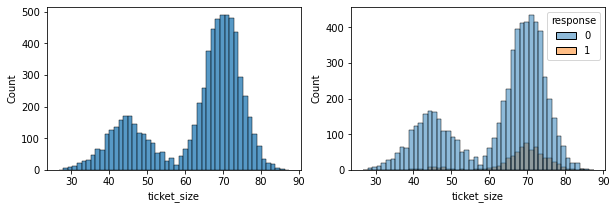

In [18]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
sns.histplot(data=df, x='ticket_size',bins=50, ax=axes[0])
sns.histplot(data=df, x='ticket_size',bins=50, hue='response', ax=axes[1])
plt.show();

In [19]:
from sklearn.mixture import GaussianMixture

data = df[['ticket_size']].copy()
gm = GaussianMixture(n_components=2, random_state=random_state).fit(data)
labels = gm.predict(data)
prob = gm.predict_proba(data)
data['is_big_spender'] = (labels == 0).astype('int')
data['prob_big_spender'] = np.round(prob[:,0],6)
data['response'] = df['response']
print(gm.means_)

[[70.08323314]
 [44.66766957]]


In [21]:
temp = data.groupby('is_big_spender').agg(count=('ticket_size','size'), response=('response','sum'))
temp['% response'] = temp['response'] / temp['count']
temp

,count,response,% response
is_big_spender,,,
0,1889,51,0.026998
1,4995,596,0.119319


In [22]:
df = df.join(data[['is_big_spender','prob_big_spender']])
df.head()

,response,recency,frequency,monetary,tenure,length_of_stay,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,recency_score,monetary_6m,frequency_6m,ticket_size_6m,monthly_spend_6m,monthly_visit_6m,monetary_12m,frequency_12m,ticket_size_12m,monthly_spend_12m,monthly_visit_12m,monetary_18m,frequency_18m,ticket_size_18m,monthly_spend_18m,monthly_visit_18m,monetary_24m,frequency_24m,ticket_size_24m,monthly_spend_24m,monthly_visit_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_12,velocity_monetary_12_18,velocity_monetary_12_24,is_big_spender,prob_big_spender
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,-0.410827,98.0,2.0,49.000000,16.333333,0.333333,251.0,4.0,62.750000,20.916667,0.333333,322.0,5.0,64.400000,17.888889,0.277778,358.0,6.0,59.666667,14.916667,0.250000,2.342629,2.739130,3.284916,3.0,3.507764,4.206704,1,0.999823
CS1113,0,36,20,1490,1390,1354,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,-0.736928,220.0,3.0,73.333333,36.666667,0.500000,393.0,6.0,65.500000,32.750000,0.500000,446.0,7.0,63.714286,24.777778,0.388889,775.0,11.0,70.454545,32.291667,0.458333,2.239186,2.959641,2.270968,2.0,2.643498,2.028387,1,0.999999
CS1114,1,33,19,1432,1342,1309,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,-0.790139,211.0,3.0,70.333333,35.166667,0.500000,315.0,5.0,63.000000,26.250000,0.416667,652.0,9.0,72.444444,36.222222,0.500000,804.0,11.0,73.090909,33.500000,0.458333,2.679365,1.941718,2.099502,2.4,1.739264,1.880597,1,0.999999
CS1115,1,12,22,1659,1315,1303,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,-1.642995,55.0,1.0,55.000000,9.166667,0.166667,248.0,3.0,82.666667,20.666667,0.250000,590.0,8.0,73.750000,32.777778,0.444444,831.0,11.0,75.545455,34.625000,0.458333,2.661290,1.677966,1.588448,4.0,2.522034,2.387485,1,0.999999
CS1116,1,204,13,857,1359,1155,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.751171,0.0,0.0,0.000000,0.000000,0.000000,286.0,4.0,71.500000,23.833333,0.333333,333.0,5.0,66.600000,18.500000,0.277778,333.0,5.0,66.600000,13.875000,0.208333,0.000000,0.000000,0.000000,3.0,3.864865,5.153153,1,0.999395


### BTYD

just trying

In [23]:
# prep BTYD data by the definition of it
data = df[['num_repeat_periods','length_of_stay','tenure','ticket_size']].rename({'num_repeat_periods':'frequency', 'length_of_stay':'recency', 'tenure':'T', 'ticket_size':'monetary_value'}, axis=1).copy()
data.head(5)

,frequency,recency,T,monetary_value
customer_id,,,,
CS1112,14,1309,1371,67.466667
CS1113,18,1354,1390,74.500000
CS1114,18,1309,1342,75.368421
CS1115,21,1303,1315,75.409091
CS1116,12,1155,1359,65.923077


In [24]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=.04)
bgf.fit(data['frequency'], data['recency'], data['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.218242e+00,2.760371e-02,2.164138e+00,2.272345e+00
alpha,1.723415e+02,2.605502e+00,1.672347e+02,1.774483e+02
a,5.608859e-24,8.164275e-18,-1.600197e-17,1.600199e-17
b,1.634303e-11,2.378659e-05,-4.662171e-05,4.662174e-05


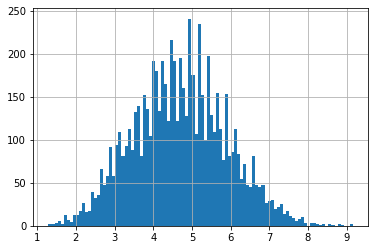

In [25]:
df['expected_num_trans_1y'] = bgf.conditional_expected_number_of_purchases_up_to_time(365, data['frequency'], data['recency'], data['T'])
df['expected_num_trans_1y'].hist(bins=100);

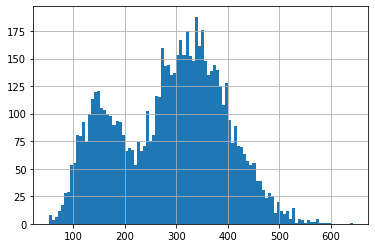

In [26]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.04)
ggf.fit(data['frequency'], data['monetary_value'])

df['clv_1y'] = ggf.customer_lifetime_value(bgf, data['frequency'], data['recency'], data['T'], data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)
df['clv_1y'].hist(bins=100);

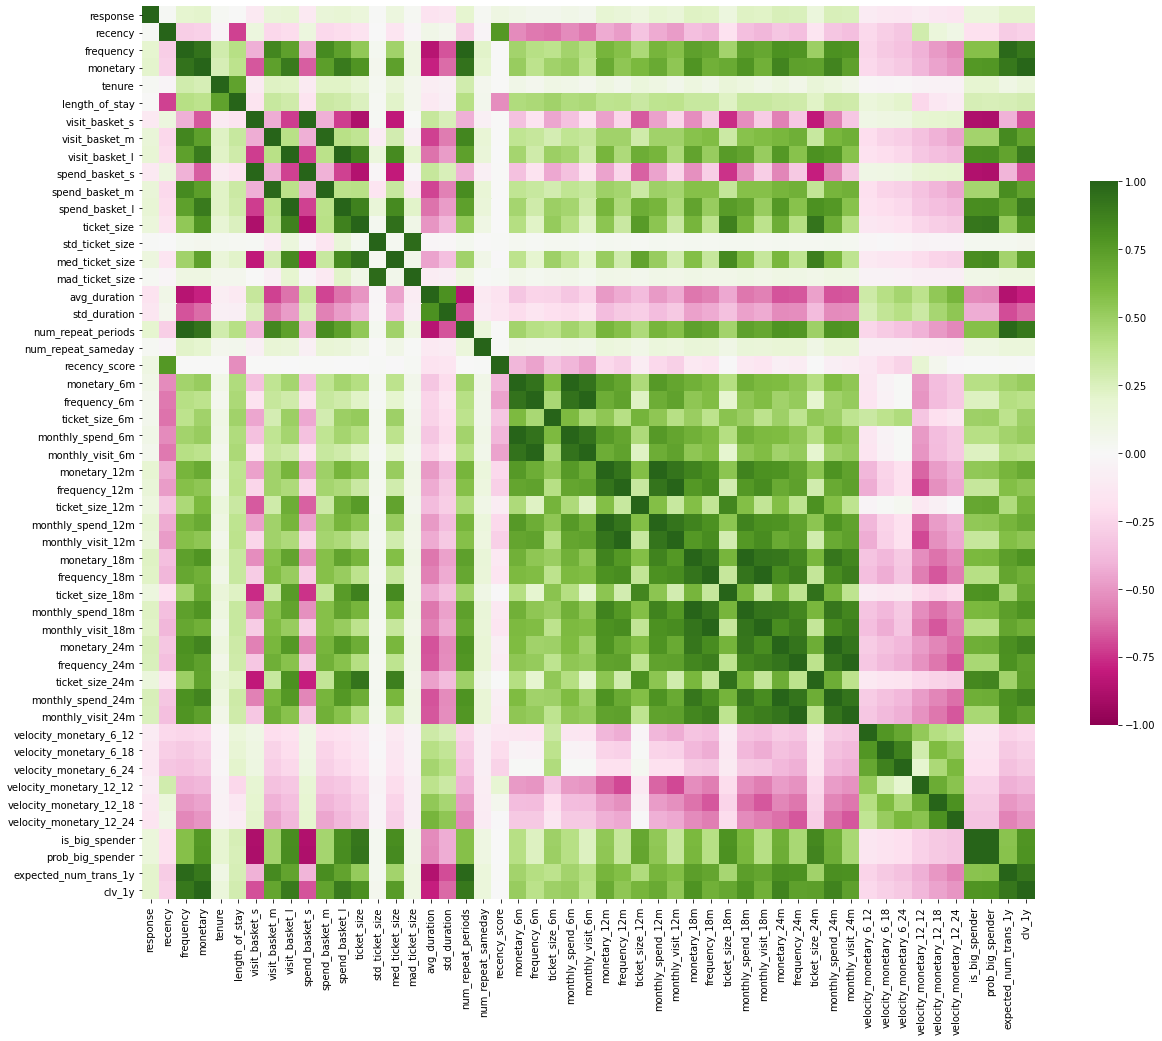

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap='PiYG', vmin=-1, vmax=1, annot=False, fmt='.1f', square=True, cbar_kws = {'shrink':.5});

In [545]:
df.to_csv('prep_customers.csv')

# EDA

In [6]:
df = pd.read_csv('prep_customers.csv', index_col=0)
print(df.shape)
df.head()

(6884, 51)


,response,recency,frequency,monetary,tenure,length_of_stay,visit_basket_s,visit_basket_m,visit_basket_l,spend_basket_s,spend_basket_m,spend_basket_l,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,recency_score,monetary_6m,frequency_6m,ticket_size_6m,monthly_spend_6m,monthly_visit_6m,monetary_12m,frequency_12m,ticket_size_12m,monthly_spend_12m,monthly_visit_12m,monetary_18m,frequency_18m,ticket_size_18m,monthly_spend_18m,monthly_visit_18m,monetary_24m,frequency_24m,ticket_size_24m,monthly_spend_24m,monthly_visit_24m,velocity_monetary_6_12,velocity_monetary_6_18,velocity_monetary_6_24,velocity_monetary_12_12,velocity_monetary_12_18,velocity_monetary_12_24,is_big_spender,prob_big_spender,expected_num_trans_1y,clv_1y
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,0,11,4,0.0,640.0,372.0,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,-0.410827,98.0,2.0,49.000000,16.333333,0.333333,251.0,4.0,62.750000,20.916667,0.333333,322.0,5.0,64.400000,17.888889,0.277778,358.0,6.0,59.666667,14.916667,0.250000,2.342629,2.739130,3.284916,3.0,3.507764,4.206704,1,0.999823,3.835611,245.539263
CS1113,0,36,20,1490,1390,1354,0,10,10,0.0,566.0,924.0,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,-0.736928,220.0,3.0,73.333333,36.666667,0.500000,393.0,6.0,65.500000,32.750000,0.500000,446.0,7.0,63.714286,24.777778,0.388889,775.0,11.0,70.454545,32.291667,0.458333,2.239186,2.959641,2.270968,2.0,2.643498,2.028387,1,0.999999,4.723460,331.954661
CS1114,1,33,19,1432,1342,1309,0,10,9,0.0,589.0,843.0,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,-0.790139,211.0,3.0,70.333333,35.166667,0.500000,315.0,5.0,63.000000,26.250000,0.416667,652.0,9.0,72.444444,36.222222,0.500000,804.0,11.0,73.090909,33.500000,0.458333,2.679365,1.941718,2.099502,2.4,1.739264,1.880597,1,0.999999,4.873180,346.462957
CS1115,1,12,22,1659,1315,1303,0,13,9,0.0,816.0,843.0,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,-1.642995,55.0,1.0,55.000000,9.166667,0.166667,248.0,3.0,82.666667,20.666667,0.250000,590.0,8.0,73.750000,32.777778,0.444444,831.0,11.0,75.545455,34.625000,0.458333,2.661290,1.677966,1.588448,4.0,2.522034,2.387485,1,0.999999,5.697856,404.175554
CS1116,1,204,13,857,1359,1155,0,8,5,0.0,399.0,458.0,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.751171,0.0,0.0,0.000000,0.000000,0.000000,286.0,4.0,71.500000,23.833333,0.333333,333.0,5.0,66.600000,18.500000,0.277778,333.0,5.0,66.600000,13.875000,0.208333,0.000000,0.000000,0.000000,3.0,3.864865,5.153153,1,0.999395,3.388962,212.904763


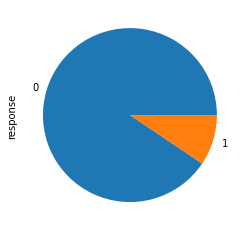

In [7]:
df['response'].value_counts().plot.pie();

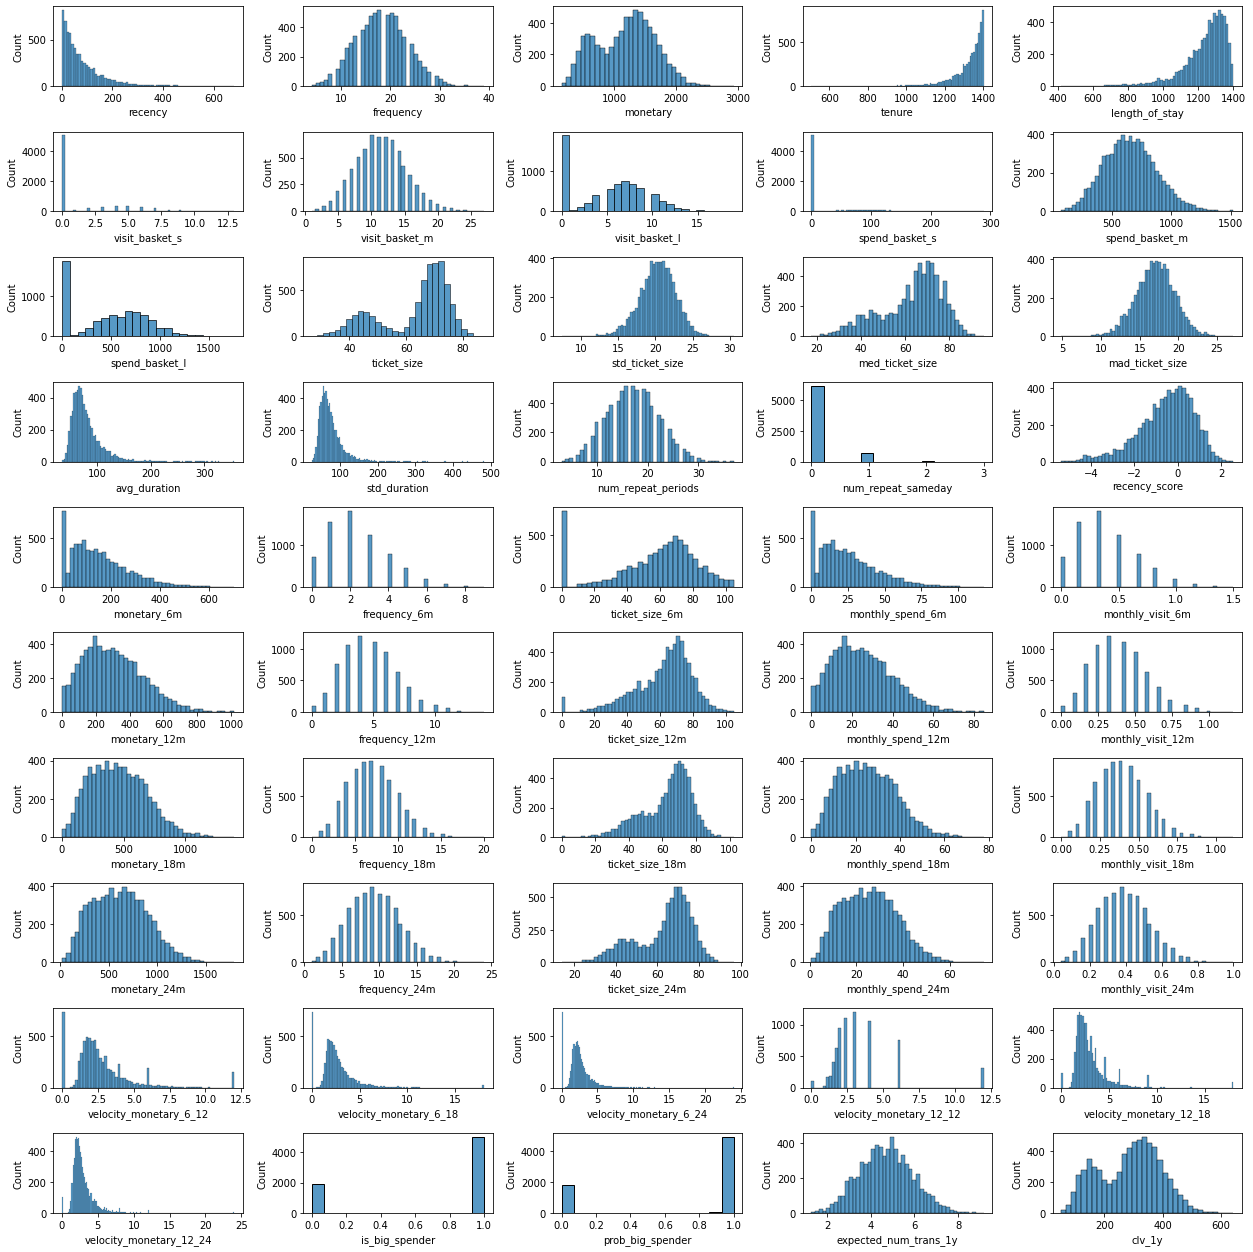

In [677]:
n_cols = 5
n_rows, mod = divmod(len(df.columns[1:]), n_cols)
n_rows +=  int(mod > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(df.columns[1:], axes):
    sns.histplot(df[col], ax=ax)
plt.show()

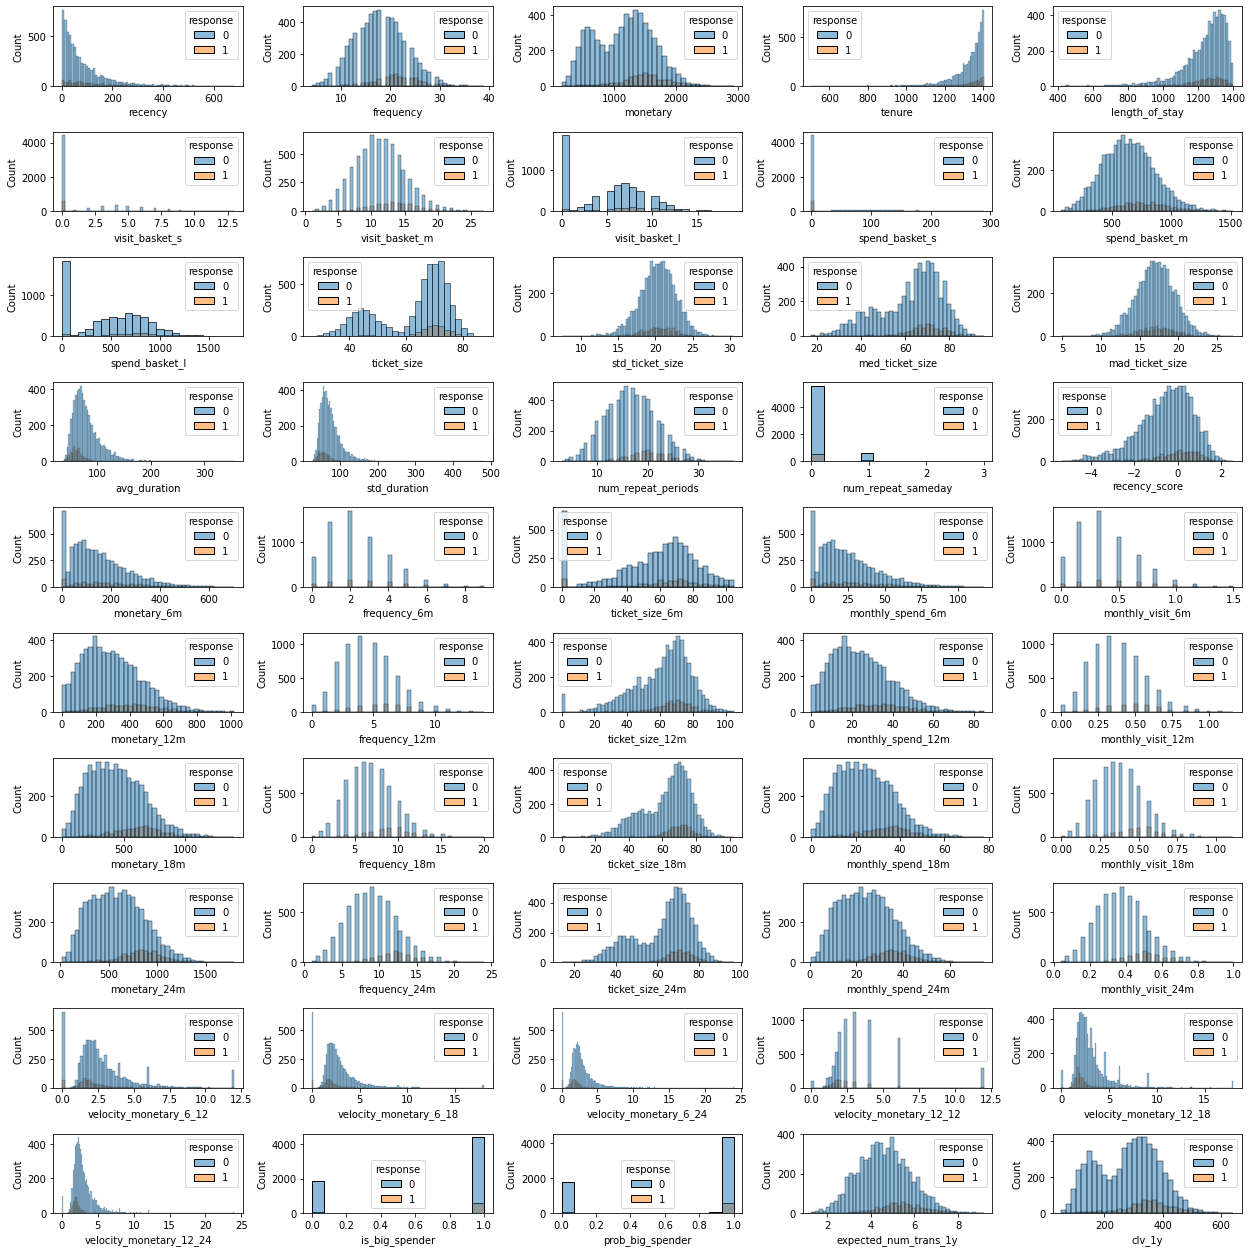

In [678]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(df.columns[1:], axes):
    sns.histplot(df, x=col, hue='response', ax=ax)
plt.show()

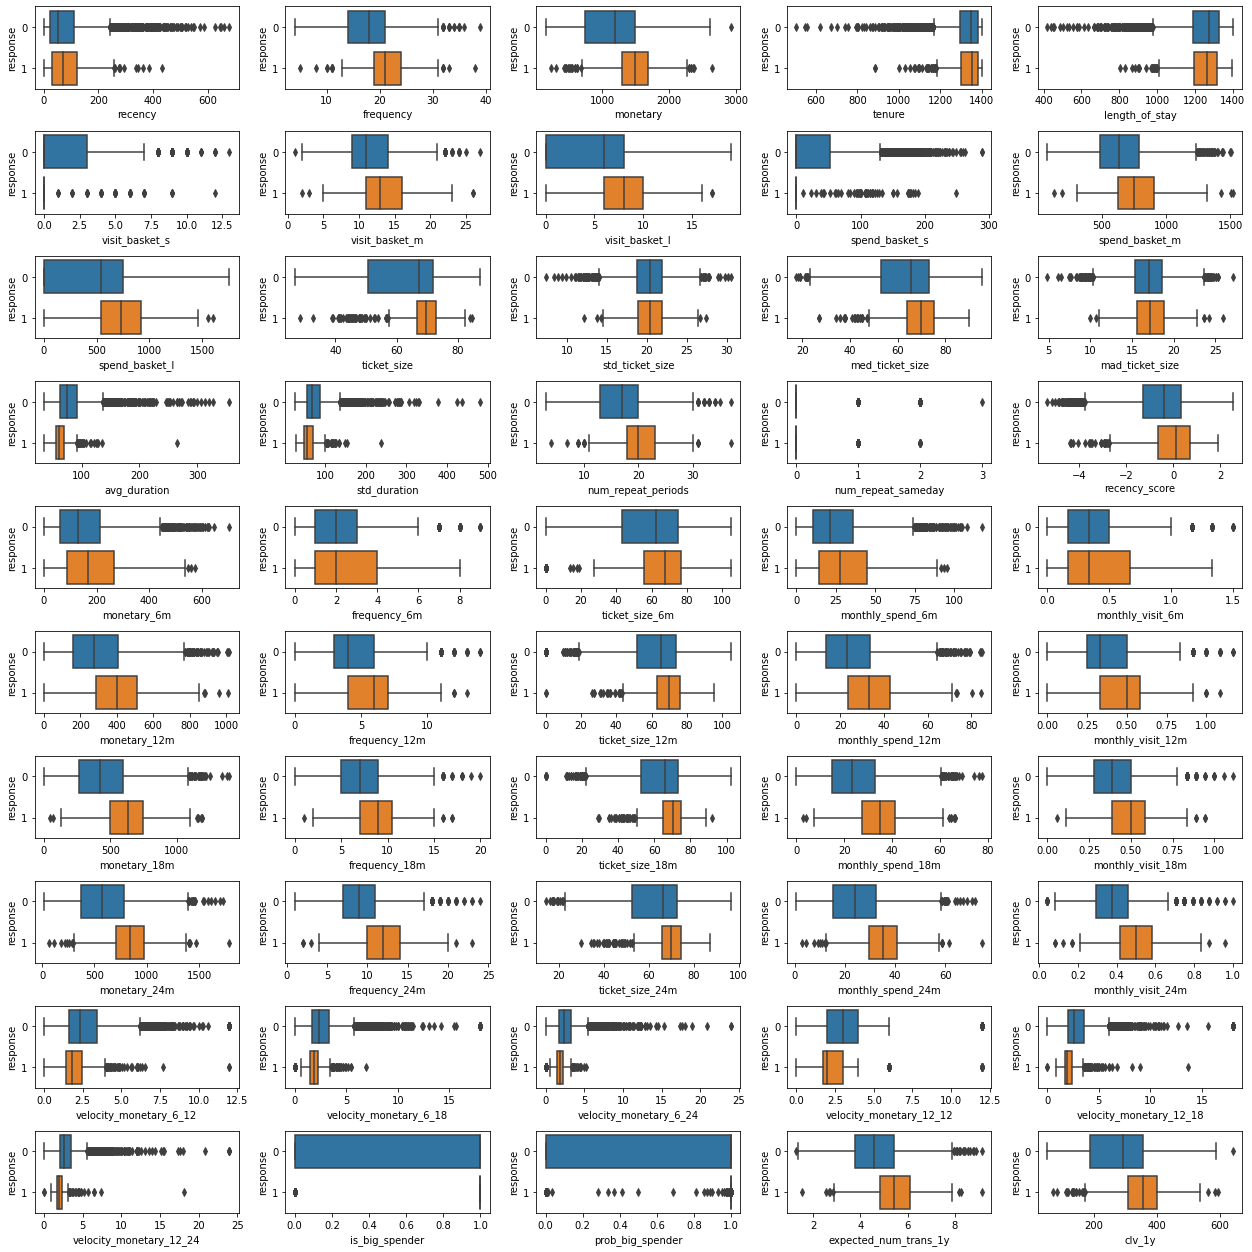

In [679]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(df.columns[1:], axes):
    sns.boxplot(data=df, y='response', x=col, ax=ax, orient='h')
plt.show()

[0.4862653  0.11539604]


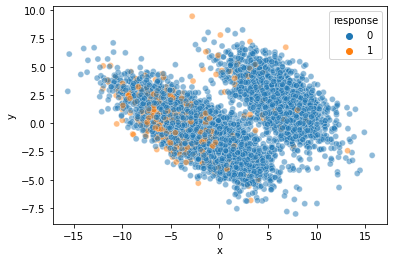

In [680]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = df.drop(['response'],axis=1)
X_std = scale(X)

pca = PCA(2)
embed = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)
sns.scatterplot(data=pd.DataFrame({'x':embed[:,0],'y':embed[:,1],'response':df['response']}), x='x', y='y', hue='response', alpha=.5);

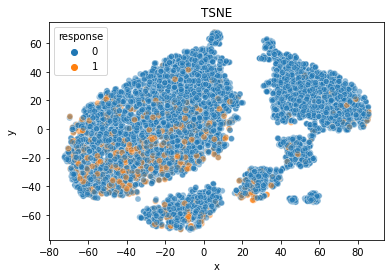

In [681]:
from sklearn.manifold import TSNE
embed_tsne = TSNE(2).fit_transform(X_std)
sns.scatterplot(data=pd.DataFrame({'x':embed_tsne[:,0],'y':embed_tsne[:,1],'response':df['response']}), x='x', y='y', hue='response', alpha=.5)
plt.title('TSNE');

In [682]:
random_state = 18

X = df.drop('response', axis=1)
y = df['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 50)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 50)
Number transactions y_test dataset:  (2066,)


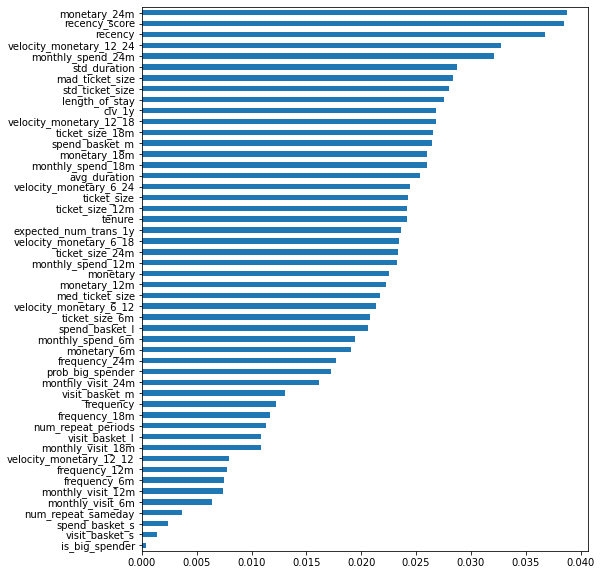

In [683]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=random_state).fit(X, y)
y_pred = clf.predict(X)
ft_imp1 = pd.Series(clf.feature_importances_, index=X.columns).sort_values()
ft_imp1.plot.barh(figsize=(8,10));

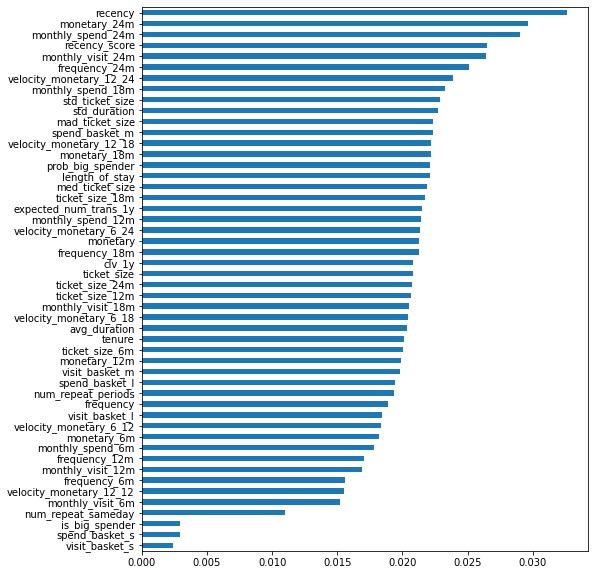

In [684]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(random_state=random_state).fit(X,y)
ft_imp2 = pd.Series(clf.feature_importances_, index=X.columns).sort_values()
ft_imp2.plot.barh(figsize=(8,10));

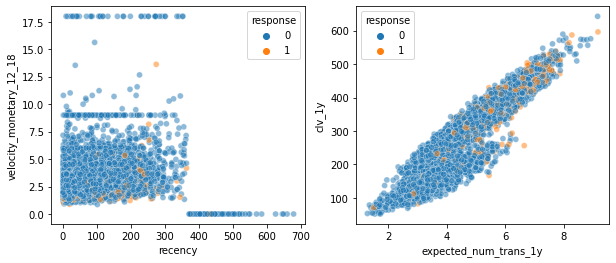

In [685]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df, x='recency', y='velocity_monetary_12_18', hue='response', alpha=.5, ax=axes[0])
sns.scatterplot(data=df, x='expected_num_trans_1y', y='clv_1y', hue='response', alpha=.5, ax=axes[1])
plt.show()

# Creating train and test sets

In [8]:
random_state = 18

exclude_fields = ['spend_basket_s','visit_basket_s','is_big_spender', 'monetary','frequency',
                  'ticket_size','std_ticket_size','mad_ticket_size','med_ticket_size',
                  'recency_score']

X = df.drop(['response'] + exclude_fields, axis=1).copy()
y = df['response']
cols = list(X.columns) + ['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 40)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 40)
Number transactions y_test dataset:  (2066,)


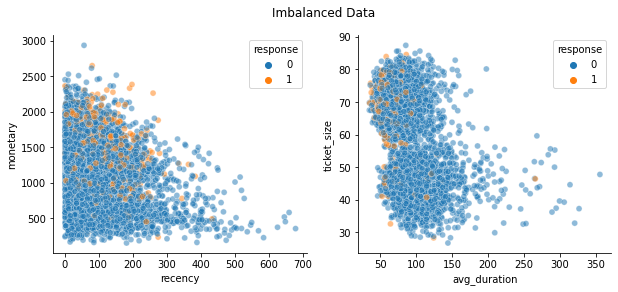

In [83]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df, x='recency', y='monetary', hue='response', alpha=.5, ax=axes[0])
sns.scatterplot(data=df, x='avg_duration', y='ticket_size', hue='response', alpha=.5, ax=axes[1])
sns.despine()
plt.suptitle("Imbalanced Data");

# Fixing imbalanced

## Undersampling

(860, 40) (860,) 0.5


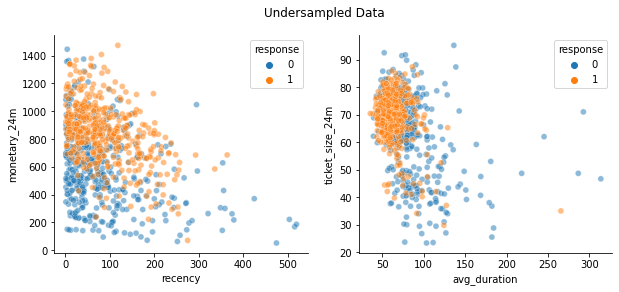

In [9]:
rus = RandomUnderSampler(random_state=random_state)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
X_undersampled = pd.DataFrame(X_undersampled, columns=X_train.columns)
y_undersampled = pd.Series(y_undersampled, name='response')
print(X_undersampled.shape, y_undersampled.shape, y_undersampled.mean())

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=X_undersampled.join(y_undersampled), x='recency', y='monetary_24m', hue='response', alpha=.5, ax=axes[0])
sns.scatterplot(data=X_undersampled.join(y_undersampled), x='avg_duration', y='ticket_size_24m', hue='response', alpha=.5, ax=axes[1])
sns.despine()
plt.suptitle("Undersampled Data");

## Oversampling

(8776, 40) (8776,) 0.5


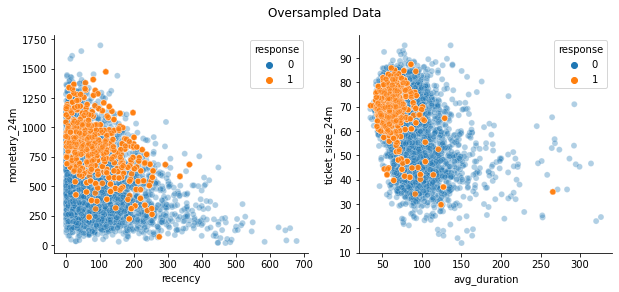

In [10]:
ros = RandomOverSampler(random_state=random_state)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
X_oversampled = pd.DataFrame(X_oversampled, columns=X_train.columns)
y_oversampled = pd.Series(y_oversampled, name='response')
print(X_oversampled.shape, y_oversampled.shape, y_oversampled.mean())

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=X_oversampled.join(y_oversampled), x='recency', y='monetary_24m', hue='response', alpha=.35, ax=axes[0])
sns.scatterplot(data=X_oversampled.join(y_oversampled), x='avg_duration', y='ticket_size_24m', hue='response', alpha=.35, ax=axes[1])
sns.despine()
plt.suptitle("Oversampled Data");

## SMOTE

(8776, 40) (8776,) 0.5


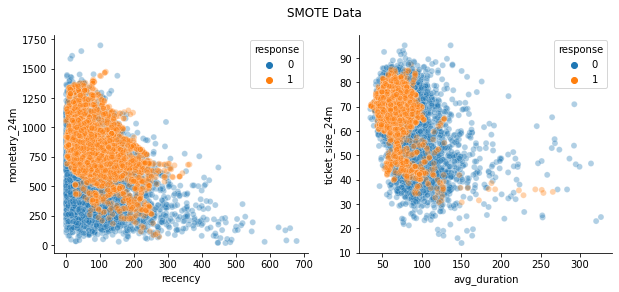

In [11]:
sm = SMOTE(random_state=random_state)
sm.fit(X_train, y_train)
X_smote, y_smote = sm.fit_sample(X_train, y_train)
X_smote = pd.DataFrame(X_smote, columns=X_train.columns)
y_smote = pd.Series(y_smote, name='response')
print(X_smote.shape, y_smote.shape, y_smote.mean())

# sns.scatterplot(data=X_smote.join(y_smote), x='recency', y='monetary', hue='response', alpha=.5)
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=X_smote.join(y_smote), x='recency', y='monetary_24m', hue='response', alpha=.35, ax=axes[0])
sns.scatterplot(data=X_smote.join(y_smote), x='avg_duration', y='ticket_size_24m', hue='response', alpha=.35, ax=axes[1])
sns.despine()
plt.suptitle("SMOTE Data");

# Modeling

In [12]:
train_sets = {
    'imbalanced' : [X_train, y_train],
    'undersampled' : [X_undersampled, y_undersampled],
    'oversampled' : [X_oversampled, y_oversampled],
    'smote' : [X_smote, y_smote],
}

## Logistic Regression

In [13]:
def init_logreg():
    return LogisticRegression(solver='liblinear', class_weight='balanced', random_state=random_state)

def train_logreg(model, data, targets):
    model.fit(data, targets)
    y_pred_train = model.predict(data)
    report_train = classification_report(targets, y_pred_train, output_dict=False)
    print('Training set')
    print(report_train)

    y_pred_test = model.predict(X_test)
    report_test = classification_report(y_test, y_pred_test, output_dict=False)
    print('Test set')
    print(report_test)
    return model

def plot_logreg_roc_curve(model, data, targets, name):
    y_score_train = model.decision_function(data)
    fpr_train, tpr_train, _ = roc_curve(targets,  y_score_train)
    auc_train = roc_auc_score(targets, y_score_train)
    plt.plot(fpr_train,tpr_train, color='tomato', label=f'Train - AUC={round(auc_train,4)}')

    y_score_test = model.decision_function(X_test)
    fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
    auc_test = roc_auc_score(y_test, y_score_test)
    plt.plot(fpr_test,tpr_test, color='dodgerblue', label=f' Test - AUC={round(auc_test,4)}')

    plt.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
    plt.title(f"{type(model).__name__} - {name}")
    plt.legend(loc=4)
    plt.show()

### Imbalanced

Training set
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      4388
           1       0.19      0.78      0.30       430

    accuracy                           0.68      4818
   macro avg       0.58      0.73      0.55      4818
weighted avg       0.90      0.68      0.75      4818

Test set
              precision    recall  f1-score   support

           0       0.95      0.69      0.80      1849
           1       0.21      0.72      0.33       217

    accuracy                           0.69      2066
   macro avg       0.58      0.70      0.56      2066
weighted avg       0.88      0.69      0.75      2066



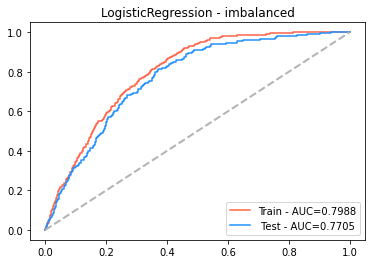

In [14]:
name = 'imbalanced'
data, targets = train_sets[name]

model = init_logreg()
model = train_logreg(model, data, targets)
plot_logreg_roc_curve(model, data, targets, name)

### Undersampled

Training set
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       430
           1       0.73      0.78      0.76       430

    accuracy                           0.75       860
   macro avg       0.75      0.75      0.75       860
weighted avg       0.75      0.75      0.75       860

Test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1849
           1       0.21      0.75      0.33       217

    accuracy                           0.68      2066
   macro avg       0.58      0.71      0.56      2066
weighted avg       0.88      0.68      0.74      2066



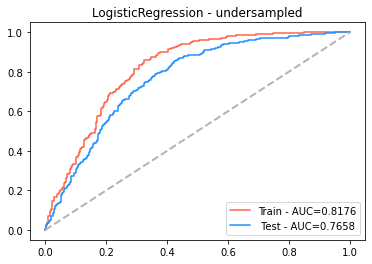

In [15]:
name = 'undersampled'
data, targets = train_sets[name]

model = init_logreg()
model = train_logreg(model, data, targets)
plot_logreg_roc_curve(model, data, targets, name)

### Oversampled

Training set
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      4388
           1       0.70      0.78      0.74      4388

    accuracy                           0.73      8776
   macro avg       0.73      0.73      0.73      8776
weighted avg       0.73      0.73      0.73      8776

Test set
              precision    recall  f1-score   support

           0       0.95      0.68      0.80      1849
           1       0.21      0.72      0.33       217

    accuracy                           0.69      2066
   macro avg       0.58      0.70      0.56      2066
weighted avg       0.88      0.69      0.75      2066



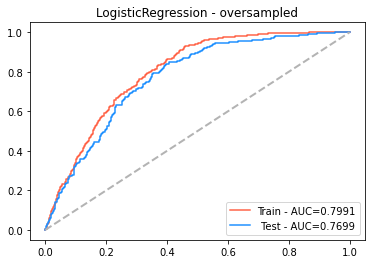

In [16]:
name = 'oversampled'
data, targets = train_sets[name]

model = init_logreg()
model = train_logreg(model, data, targets)
plot_logreg_roc_curve(model, data, targets, name)

### SMOTE

Training set
              precision    recall  f1-score   support

           0       0.77      0.67      0.72      4388
           1       0.71      0.80      0.75      4388

    accuracy                           0.74      8776
   macro avg       0.74      0.74      0.73      8776
weighted avg       0.74      0.74      0.73      8776

Test set
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1849
           1       0.20      0.69      0.32       217

    accuracy                           0.68      2066
   macro avg       0.58      0.69      0.56      2066
weighted avg       0.87      0.68      0.74      2066



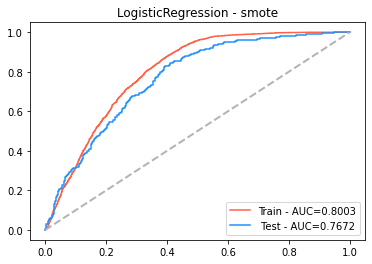

In [17]:
name = 'smote'
data, targets = train_sets[name]

model = init_logreg()
model = train_logreg(model, data, targets)
plot_logreg_roc_curve(model, data, targets, name)

## XGBoost

In [18]:
def init_xgboost_model():
    return xgb.XGBClassifier(objective ='binary:logistic', random_state=random_state,
                             colsample_bytree = 0.65,
                             learning_rate = 0.03,
                             max_depth = 3,
                             reg_alpha=12,
                             reg_lambda=12,
                             n_estimators = 500,
                             eval_metric='auc')

def train_xgboost(model, data, targets):
    return model.fit(data, targets, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

def plot_xgboost_roc_curve(model, data, targets):
    y_score_train = model.predict_proba(data)
    fpr_train, tpr_train, _ = roc_curve(targets,  y_score_train[:,1])
    auc_train = roc_auc_score(targets, y_score_train[:,1])
    plt.plot(fpr_train,tpr_train, color='tomato', label=f'Train - AUC={round(auc_train,4)}')

    y_score_test = model.predict_proba(X_test)
    fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
    auc_test = roc_auc_score(y_test, y_score_test[:,1])
    plt.plot(fpr_test,tpr_test, color='dodgerblue', label=f'Test - AUC={round(auc_test,4)}')

    plt.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
    plt.title(f"{type(model).__name__} - {name}")
    plt.legend(loc=4)
    plt.show()

### Undersampled

XGBoost model - Oversampled
[0]	validation_0-auc:0.707761
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.717269
[2]	validation_0-auc:0.756096
[3]	validation_0-auc:0.752599
[4]	validation_0-auc:0.757729
[5]	validation_0-auc:0.758008
[6]	validation_0-auc:0.75817
[7]	validation_0-auc:0.760219
[8]	validation_0-auc:0.761855
[9]	validation_0-auc:0.762336
[10]	validation_0-auc:0.762513
[11]	validation_0-auc:0.765305
[12]	validation_0-auc:0.764628
[13]	validation_0-auc:0.766588
[14]	validation_0-auc:0.766617
[15]	validation_0-auc:0.76494
[16]	validation_0-auc:0.766781
[17]	validation_0-auc:0.767615
[18]	validation_0-auc:0.767548
[19]	validation_0-auc:0.767523
[20]	validation_0-auc:0.766177
[21]	validation_0-auc:0.766237
[22]	validation_0-auc:0.766136
[23]	validation_0-auc:0.765732
[24]	validation_0-auc:0.765423
[25]	validation_0-auc:0.765765
[26]	validation_0-auc:0.768117
[27]	validation_0-auc:0.769312
[28]	validation_0-auc:0.769724
[29]	validation_0-auc

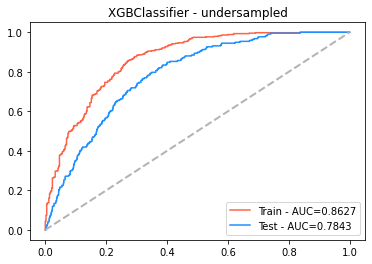

In [19]:
name = 'undersampled'
data, targets = train_sets[name]

print('XGBoost model - Oversampled')
model = init_xgboost_model()
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)

### SMOTE

XGBoost model - SMOTE
[0]	validation_0-auc:0.740917
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.741421
[2]	validation_0-auc:0.755297
[3]	validation_0-auc:0.76675
[4]	validation_0-auc:0.766533
[5]	validation_0-auc:0.767645
[6]	validation_0-auc:0.768266
[7]	validation_0-auc:0.771602
[8]	validation_0-auc:0.77135
[9]	validation_0-auc:0.774217
[10]	validation_0-auc:0.773638
[11]	validation_0-auc:0.773893
[12]	validation_0-auc:0.776328
[13]	validation_0-auc:0.775781
[14]	validation_0-auc:0.775087
[15]	validation_0-auc:0.775948
[16]	validation_0-auc:0.77542
[17]	validation_0-auc:0.774689
[18]	validation_0-auc:0.775612
[19]	validation_0-auc:0.775357
[20]	validation_0-auc:0.775932
[21]	validation_0-auc:0.775628
[22]	validation_0-auc:0.775503
[23]	validation_0-auc:0.774793
[24]	validation_0-auc:0.775867
[25]	validation_0-auc:0.775757
[26]	validation_0-auc:0.776018
[27]	validation_0-auc:0.775924
[28]	validation_0-auc:0.775865
[29]	validation_0-auc:0.7768

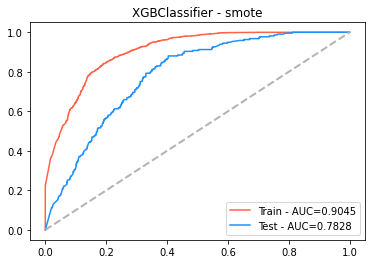

In [20]:
name = 'smote'
data, targets = train_sets[name]

print('XGBoost model - SMOTE')
model = init_xgboost_model()
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)

### Oversampled (Chosen)

XGBoost model - Oversampled
[0]	validation_0-auc:0.776248
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.777257
[2]	validation_0-auc:0.78556
[3]	validation_0-auc:0.785577
[4]	validation_0-auc:0.785358
[5]	validation_0-auc:0.786289
[6]	validation_0-auc:0.786291
[7]	validation_0-auc:0.785542
[8]	validation_0-auc:0.786245
[9]	validation_0-auc:0.785475
[10]	validation_0-auc:0.786007
[11]	validation_0-auc:0.786253
[12]	validation_0-auc:0.785373
[13]	validation_0-auc:0.786185
[14]	validation_0-auc:0.786376
[15]	validation_0-auc:0.785578
[16]	validation_0-auc:0.785931
[17]	validation_0-auc:0.787615
[18]	validation_0-auc:0.792139
[19]	validation_0-auc:0.79513
[20]	validation_0-auc:0.793726
[21]	validation_0-auc:0.793242
[22]	validation_0-auc:0.792774
[23]	validation_0-auc:0.79198
[24]	validation_0-auc:0.79122
[25]	validation_0-auc:0.791359
[26]	validation_0-auc:0.792304
[27]	validation_0-auc:0.792836
[28]	validation_0-auc:0.792856
[29]	validation_0-auc:0

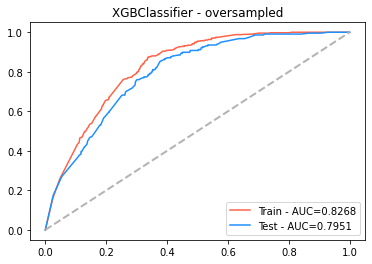

In [21]:
name = 'oversampled'
data, targets = train_sets[name]

print('XGBoost model - Oversampled')
model = init_xgboost_model()
model = train_xgboost(model, data, targets)

y_pred_train =  model.predict(data)
report_train = classification_report(targets, y_pred_train)
print('training set')
print(report_train) 

y_pred_test = model.predict(X_test)
report_test = classification_report(y_test, y_pred_test)
print('test set')
print(report_test) 

plot_xgboost_roc_curve(model, data, targets)

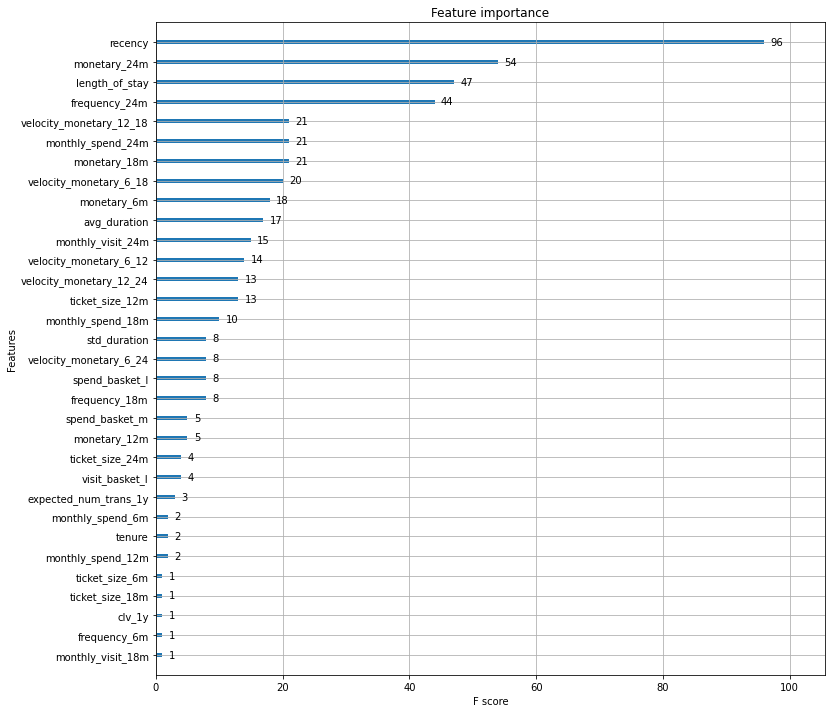

In [22]:
plt.figure(figsize=(12,12))
ax = plt.gca()
xgb.plot_importance(model, ax=ax);

# Future improvements

- Proper implementation by using train-valid-test and cross validation  
an expert suggests that this seems overfitting to the test-set
- SHAP Tree Explainer
- Feature selection
- Hyperparameter Tuning, try Optuna
- Include LightGBM
